# The goal of this assignment was to classify names by their nationality. 
### Some of the helper functions in the first block were provided by Professor Anand as part of the project

In [3]:
#!/usr/bin/env python
# coding: utf-8
# Refactored the example code to gather all imports and most definitions to the top chunk

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import torch.nn as nn
import torch.utils.data
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))



import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# %%
# Build the names dictionary, a list of names per language
# di tionary keys are languages, values are names
names = {}
languages = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines

n_categories = len(languages)

def findName(dict, name):
    keys = dict.keys()
    for key in keys:
        if name in dict[key]:
            return key
    return ''

# %% 
# Turning Names into Tensors
# --------------------------
# 
# Now that we have all the names organized, we need to turn them into
# Tensors to make any use of them.
# 
# To represent a single letter, we use a "one-hot vector" of size
# ``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
# at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.
# 
# To make a word we join a bunch of those into a 2D matrix
# ``<line_length x 1 x n_letters>``.
# 
# That extra 1 dimension is because PyTorch assumes everything is in
# batches - we're just using a batch size of 1 here.
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()
    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def predict(name, n_predictions=3):
    print('\n> %s' % name)
    with torch.no_grad():
        output = evaluate(nameToTensor(name))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, languages[category_index]))
            predictions.append([value, languages[category_index]])

            
# Used to get a random datapoint from the given list (of dicts) of names and languages.
# When ran until the languages list is empty, it will have sampled every datapoint in a random order.
def getTrainingExample(n, l): # sample without replacement the entire dataset
    category = randomChoice(l)
    name = randomChoice(n[category])
    n[category].remove(name)
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    if (len(n[category]) == 0):
        l.remove(category)
    return category, name, category_tensor, name_tensor

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


In [4]:
print(n_letters)

57


In [2]:
# %% Creating the Network
# ====================
# 
# Before autograd, creating a recurrent neural network in Torch involved
# cloning the parameters of a layer over several timesteps. The layers
# held hidden state and gradients which are now entirely handled by the
# graph itself. This means you can implement a RNN in a very "pure" way,
# as regular feed-forward layers.
# 
# This RNN module (mostly copied from `the PyTorch for Torch users
# tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
# nn_tutorial.html#example-2-recurrent-net>`__)
# is just 2 linear layers which operate on an input and hidden state, with
# a LogSoftmax layer after the output.
# 
# .. figure:: https://i.imgur.com/Z2xbySO.png
#    :alt:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 32 # 1.1 - Hidden size of 32
rnn = RNN(n_letters, n_hidden, n_categories)


In [3]:

# %% Training the Network
# --------------------
# 
# Now all it takes to train the network is show it a bunch of examples,
# have it make guesses, and compare its output against labels.
# 
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
# 
criterion = nn.NLLLoss()

# Each loop of training will:
# 
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
# 
#    -  Keep hidden state for next letter
# 
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
# 
# Learning rate kept at .005 for part 1.1
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

In [4]:

# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
# 
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []


start = time.time()

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 5s) 2.8163 Trieu / Czech ✗ (Vietnamese)
10000 10% (0m 11s) 2.8283 Skwor / Scottish ✗ (Czech)
15000 15% (0m 17s) 3.2792 Paul / Vietnamese ✗ (French)
20000 20% (0m 22s) 2.8315 Charron / Scottish ✗ (French)
25000 25% (0m 28s) 1.7214 Urbanovska / Polish ✗ (Czech)
30000 30% (0m 33s) 2.7365 Schoorl / German ✗ (Dutch)
35000 35% (0m 39s) 2.9206 Leeuwenhoeck / Irish ✗ (Dutch)
40000 40% (0m 45s) 3.2105 Close / French ✗ (Greek)
45000 45% (0m 50s) 0.0085 Haritopoulos / Greek ✓
50000 50% (0m 56s) 1.6368 Brown / Scottish ✓
55000 55% (1m 1s) 0.0288 Imamaliev / Russian ✓
60000 60% (1m 7s) 1.0895 Mansour / Arabic ✓
65000 65% (1m 13s) 1.0485 Krusen / Dutch ✓
70000 70% (1m 18s) 1.4708 Rahal / Arabic ✓
75000 75% (1m 24s) 0.5219 Martinez / Spanish ✓
80000 80% (1m 29s) 0.9344 Chieu / Chinese ✓
85000 85% (1m 35s) 1.9469 Chu / Vietnamese ✗ (Chinese)
90000 90% (1m 40s) 2.8458 Silva / Czech ✗ (Portuguese)
95000 95% (1m 46s) 0.1945 Choi / Korean ✓
100000 100% (1m 52s) 0.1376 Jdanov / Russian ✓


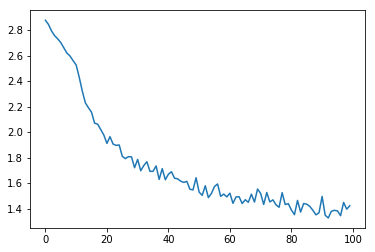

In [5]:
# Plotting the Results
# --------------------
# 
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

# Loss
plt.figure()
plt.plot(all_losses)

Accuracy is 0.536664


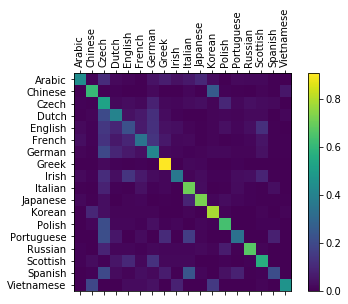

In [6]:
# Evaluating the Results
# ======================
# 
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
# 

# In[14]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)

# Code for evaluating the model's accuracy on every datapoint
ename = copy.deepcopy(names)
elang = copy.deepcopy(languages)
while (len(elang) != 0):
    category, name, category_tensor, name_tensor = getTrainingExample(ename, elang)
    output = evaluate(name_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = languages.index(category)
    confusion[category_i][guess_i] += 1

    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Classification 
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

The accuracy for hidden size of 32 was between .49 to .64, depending on the iteration

5000 5% (0m 5s) 2.7574 Youj / Korean ✓
10000 10% (0m 11s) 1.9167 Damhan / Arabic ✗ (Irish)
15000 15% (0m 17s) 3.1937 Vann / Vietnamese ✗ (Dutch)
20000 20% (0m 23s) 0.9821 Tian / Chinese ✓
25000 25% (0m 29s) 1.1745 Marino / Italian ✓
30000 30% (0m 35s) 0.7674 Raghailligh / Irish ✓
35000 35% (0m 41s) 1.7338 Paredes / Dutch ✗ (Portuguese)
40000 40% (0m 47s) 0.8182 To / Vietnamese ✓
45000 45% (0m 53s) 1.2505 Chang / Chinese ✗ (Korean)
50000 50% (0m 58s) 0.2367 Jachmenev / Russian ✓
55000 55% (1m 4s) 1.6305 Kavanagh / Russian ✗ (Irish)
60000 60% (1m 10s) 1.8993 Christie / French ✗ (Scottish)
65000 65% (1m 16s) 2.9347 Sorge / French ✗ (German)
70000 70% (1m 22s) 2.2078 Daishi / Arabic ✗ (Japanese)
75000 75% (1m 28s) 2.3833 Flores / Portuguese ✗ (Spanish)
80000 80% (1m 34s) 0.0944 Gwang  / Korean ✓
85000 85% (1m 40s) 4.3739 Katsuba / Japanese ✗ (Russian)
90000 90% (1m 46s) 1.2163 Aritza / Portuguese ✗ (Spanish)
95000 95% (1m 52s) 0.4792 Hadad / Arabic ✓
100000 100% (1m 57s) 3.1765 Brisbois / 

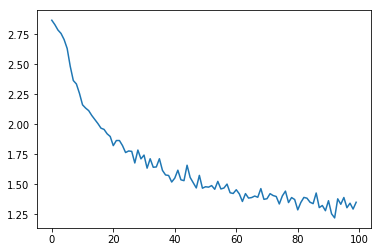

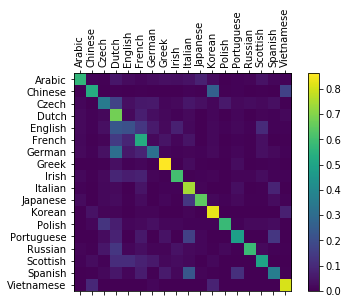

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 64 # 1.1 - hidden state size of 64
n_iters = 100000
print_every = 5000
plot_every = 1000
rnn = RNN(n_letters, n_hidden, n_categories)
current_loss = 0
all_losses = []
start = time.time()

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
confusion = torch.zeros(n_categories, n_categories)

# Code for evaluating the model's accuracy on every datapoint
ename = copy.deepcopy(names)
elang = copy.deepcopy(languages)
while (len(elang) != 0):
    category, name, category_tensor, name_tensor = getTrainingExample(ename, elang)
    output = evaluate(name_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = languages.index(category)
    confusion[category_i][guess_i] += 1

    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Loss
plt.figure()
plt.plot(all_losses)

# Classification
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

The accuracy for hidden size of 64 was about .58 (.652 when trained for 500,000 epochs)

5000 5% (0m 6s) 2.5508 Jagoda / Japanese ✗ (Polish)
10000 10% (0m 12s) 0.9161 Aihara / Japanese ✓
15000 15% (0m 18s) 2.4719 Kallik / Czech ✗ (Russian)
20000 20% (0m 24s) 1.6262 Gonzales / Greek ✗ (Spanish)
25000 25% (0m 30s) 1.5846 Hanraets / Dutch ✓
30000 30% (0m 36s) 0.9887 Bazzoli / Italian ✓
35000 35% (0m 42s) 1.0036 Christie / Scottish ✓
40000 40% (0m 48s) 1.6329 Sung / Chinese ✗ (Korean)
45000 45% (0m 54s) 0.3970 Thai / Vietnamese ✓
50000 50% (1m 0s) 0.4286 O'Connell / Irish ✓
55000 55% (1m 6s) 1.5035 Joubert / Dutch ✗ (French)
60000 60% (1m 11s) 2.0673 Rann / Irish ✗ (English)
65000 65% (1m 17s) 0.8797 Abrazhevich / Russian ✓
70000 70% (1m 23s) 0.7939 Luc / Vietnamese ✓
75000 75% (1m 29s) 0.7221 Shakhgildyan / Russian ✓
80000 80% (1m 35s) 3.0725 Jonas / Greek ✗ (Czech)
85000 85% (1m 41s) 3.0449 Tang / Vietnamese ✗ (Chinese)
90000 90% (1m 47s) 0.1674 Nahas / Arabic ✓
95000 95% (1m 53s) 1.5366 Knepp / Dutch ✗ (German)
100000 100% (1m 59s) 1.0234 Tahan / Arabic ✓
Accuracy is 0.5868

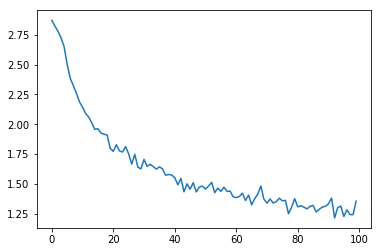

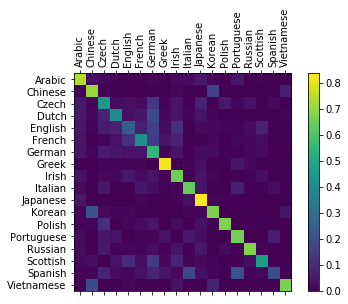

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128 # 1.1 - hidden state size of 128
n_iters = 100000
print_every = 5000
plot_every = 1000
rnn = RNN(n_letters, n_hidden, n_categories)
current_loss = 0
all_losses = []
start = time.time()

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
confusion = torch.zeros(n_categories, n_categories)

# Code for evaluating the model's accuracy on every datapoint
ename = copy.deepcopy(names)
elang = copy.deepcopy(languages)
while (len(elang) != 0):
    category, name, category_tensor, name_tensor = getTrainingExample(ename, elang)
    output = evaluate(name_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = languages.index(category)
    confusion[category_i][guess_i] += 1

    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Loss
plt.figure()
plt.plot(all_losses)

# Classification
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

The accuracy for hidden size of 128 was about .45-.59 (.631 when trained for 500,000 epochs)

In [9]:
findName(names,'Dostoevsky')
predict('Dostoevsky')
findName(names,'Jackson')
predict('Jackson')
findName(names,'Satoshi')
predict('Satoshi')
predict('Bernal')


> Dostoevsky
(-0.37) Russian
(-1.30) Czech
(-4.41) English

> Jackson
(-0.67) Scottish
(-1.29) English
(-2.88) Russian

> Satoshi
(-0.89) Japanese
(-1.19) Arabic
(-2.14) Italian

> Bernal
(-1.00) Czech
(-1.23) German
(-2.55) Arabic


Question 1.2  
Originally I made a function which randomly sampled (without replacement) from the dataset. This function is now used only in the evaluation function. I instead was unhappy with it, and was getting very poor results, so I instead defined a dataset and dataloader with a batch size of 1 and shuffle = True, which when enumerated returns the whole dataset in a random order one at a time. For part 2 this same code should be able to be reused with larger batch sizes. 
After training (and implementing a decaying learning rate), I got accuracy ratings around .75 for all 3 sizes of network.

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = []
        for d in names:
            temp = []
            for n in names[d]:
                temp.append((d, n))
            self.data += temp
        
    def __getitem__(self, index):
        item = self.data[index]
        name = item[1]
        lang = item[0]
        # nameToTensor(name), torch.tensor(lang, dtype=torch.long)
        return {'data': name, 'target': lang}
    
    def __len__(self):
        return len(self.data)

dataset = MyDataset()
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle = True
)

1 20% (0m 18s) 1.1378 Zogby / Arabic ✓
2 40% (0m 36s) 1.0196 Wickham / English ✓
3 60% (0m 54s) 1.3176 Salib / Arabic ✓
4 80% (1m 12s) 1.0194 Pattison / Russian ✗ (English)
5 100% (1m 30s) 0.0028 Vyalov / Russian ✓
Accuracy is 0.739813


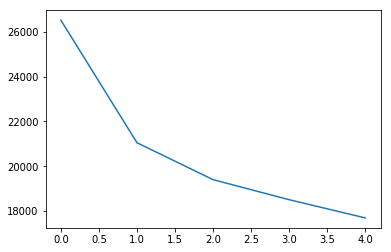

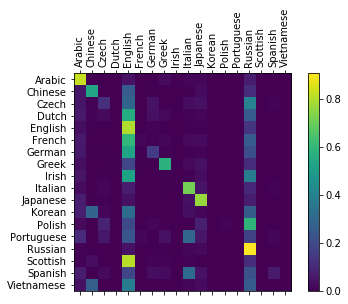

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 32 # 1.2 - hidden state size of 32
n_iters = 5 # Training for 5 epochs
print_every = 1
plot_every = 1
rnn = RNN(n_letters, n_hidden, n_categories)
current_loss = 0
all_losses = []
start = time.time()
learning_rate = .01

for iter in range(1, n_iters + 1):
    for i_batch, sample_batched in enumerate(loader):        # gives batch data
        #category, name, category_tensor, name_tensor = getTrainingExample(ename, elang)
        name = sample_batched['data'][0]
        category = sample_batched['target'][0]
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output, loss = train(category_tensor, name_tensor)
        current_loss += loss
        if i_batch % 1000 == 0:
            learning_rate /= 1.01

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

confusion = torch.zeros(n_categories, n_categories)

# Code for evaluating the model's accuracy on every datapoint
ename = copy.deepcopy(names)
elang = copy.deepcopy(languages)
while (len(elang) != 0):
    category, name, category_tensor, name_tensor = getTrainingExample(ename, elang)
    output = evaluate(name_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = languages.index(category)
    confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

plt.figure()
plt.plot(all_losses)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

1 20% (0m 19s) 0.3241 Ableuhoff / Russian ✓
2 40% (0m 38s) 1.2578 Kawagichi / Italian ✗ (Japanese)
3 60% (0m 57s) 1.0796 Hogan / English ✓
4 80% (1m 16s) 0.0175 Dobrushkin / Russian ✓
5 100% (1m 35s) 3.5380 Azzara / Arabic ✗ (Italian)
Accuracy is 0.759938


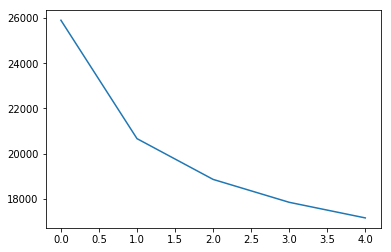

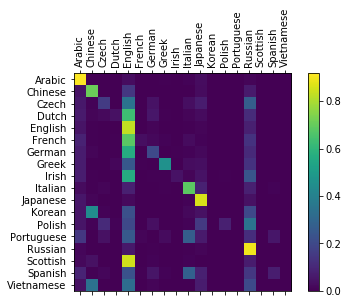

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 64 # 1.2 - hidden state size of 64
n_iters = 5 # Training for 5 epochs
print_every = 1
plot_every = 1
rnn = RNN(n_letters, n_hidden, n_categories)
current_loss = 0
all_losses = []
start = time.time()
learning_rate = .01

for iter in range(1, n_iters + 1):
    for i_batch, sample_batched in enumerate(loader):        # gives batch data
        #category, name, category_tensor, name_tensor = getTrainingExample(ename, elang)
        name = sample_batched['data'][0]
        category = sample_batched['target'][0]
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output, loss = train(category_tensor, name_tensor)
        current_loss += loss
        if i_batch % 1000 == 0:
            learning_rate /= 1.01

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

confusion = torch.zeros(n_categories, n_categories)

# Code for evaluating the model's accuracy on every datapoint
ename = copy.deepcopy(names)
elang = copy.deepcopy(languages)
while (len(elang) != 0):
    category, name, category_tensor, name_tensor = getTrainingExample(ename, elang)
    output = evaluate(name_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = languages.index(category)
    confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

plt.figure()
plt.plot(all_losses)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

1 20% (0m 26s) 0.2674 Nevelsky / Russian ✓
2 40% (0m 52s) 0.0050 Paidoverov / Russian ✓
3 60% (1m 19s) 0.3114 Poryadin / Russian ✓
4 80% (1m 45s) 0.0379 Abdulazizoff / Russian ✓
5 100% (2m 12s) 0.3729 Schumacher / German ✓
Accuracy is 0.756700


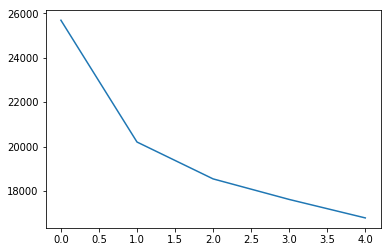

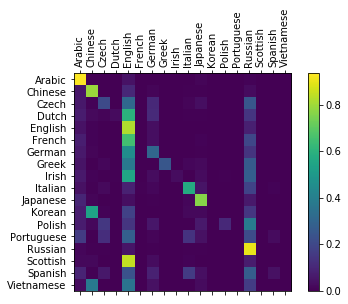

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128 # 1.2 - hidden state size of 128
n_iters = 5 # Training for 5 epochs
print_every = 1
plot_every = 1
rnn = RNN(n_letters, n_hidden, n_categories)
current_loss = 0
all_losses = []
start = time.time()
learning_rate = .01

for iter in range(1, n_iters + 1):
    for i_batch, sample_batched in enumerate(loader):        # gives batch data
        #category, name, category_tensor, name_tensor = getTrainingExample(ename, elang)
        name = sample_batched['data'][0]
        category = sample_batched['target'][0]
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output, loss = train(category_tensor, name_tensor)
        current_loss += loss
        if i_batch % 1000 == 0:
            learning_rate /= 1.01

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

confusion = torch.zeros(n_categories, n_categories)

# Code for evaluating the model's accuracy on every datapoint
ename = copy.deepcopy(names)
elang = copy.deepcopy(languages)
while (len(elang) != 0):
    category, name, category_tensor, name_tensor = getTrainingExample(ename, elang)
    output = evaluate(name_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = languages.index(category)
    confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

plt.figure()
plt.plot(all_losses)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()